Importing Needed Libraries

In [1]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dedalus.public as d3
from scipy.stats import skew
import cmocean.cm as cmo
from scipy import signal
from scipy import signal
from scipy.fft import fft, fftshift

Loading the data

diagname captures the longtime energy quantities

In [2]:
Lx = 60
Ly = 30
Domain = Lx*Ly
Nx = 512
Ny = 256

dealias = 3/2
dtype = np.float64

#Physical Parameters
delx = Lx/Nx
nu2 = (delx)**2*4
lambda_scale = Lx / 50 / (2 * np.pi)
beta = 0.05
k_d = 1

U= '5'
A= '60'
S= '60'
T= '50'

diagname = '/scratch/ql2221/dedalus_sing/Channel/channel_diag_U' + U + 'A' + A + 'S' + S +'T' + T + '/channel_diag_U' + U + 'A' + A + 'S' + S +'T' + T + '_s1.h5'

with h5py.File(diagname, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))
    
    dg_time_ary = np.array(file['scales']['sim_time'])
    print(dg_time_ary[-1])


    
    # KE1 = np.array(file['tasks']['KE1'])
    # KE2 = np.array(file['tasks']['KE2'])
    # APE = np.array(file['tasks']['APE'])
    EKE1 = np.array(file['tasks']['EKE1'])
    print(EKE1.size)
    EKE2 = np.array(file['tasks']['EKE2'])
    EFH = np.array(file['tasks']['EFH'])


['scales', 'tasks']
<HDF5 group "/scales" (6 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'write_number']
<HDF5 group "/tasks" (5 members)>
['EFH', 'EKE1', 'EKE2', 'TG', 'U1_mean']
49999.937323852144
500000


In [3]:
EKE_size =  EKE1.size
if EKE1.size % 2 != 0:
    EKE_size = EKE_size - 1
    EKE1 = EKE1[:EKE_size]
print(EKE1.size)

500000


plotting EKE and ZE

In [4]:
EKE1 = EKE1 * Domain
EKE2 = EKE2 * Domain

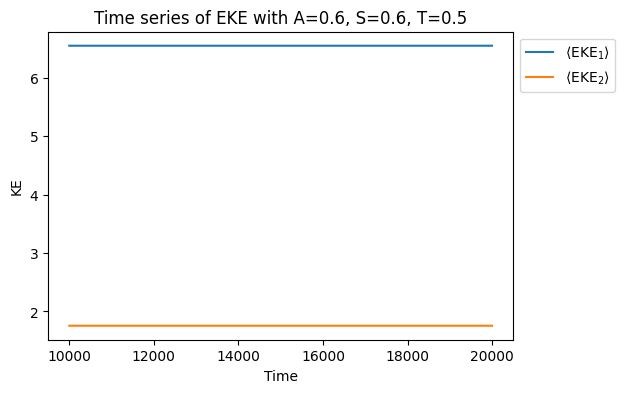

In [5]:
fig=plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
minlen = min(len(dg_time_ary[::10]), len(EKE1[::10,:,:].ravel()))
ax.plot(dg_time_ary[::10][10000:20000], EKE1[::10,:,:].ravel()[10000:20000], label=r"$\langle{\mathrm{EKE}_1}\rangle$")
ax.plot(dg_time_ary[::10][10000:20000], EKE2[::10,:,:].ravel()[10000:20000], label=r"$\langle{\mathrm{EKE}_2}\rangle$")
ax.set_ylabel("KE")
ax.set_xlabel("Time")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# ax2.plot(0,0); ax2.plot(0,0)
# ax2.plot(dg_time_ary[::10][:20000],(ZKE1[::10,:,:]+ZKE2[::10,:,:]+ZAPE[::10,:,:]).ravel()[:20000],label=r"$\langle{\mathrm{ZE}}\rangle$")
# # ax2.set_ylim(50,100)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.set_title(f"Time series of EKE with A={int(A)/100}, S={int(S)/100}, T={int(T)/100}")
figname = "A" + A + "S" + S + "T" + T 
plt.savefig(figname, bbox_inches='tight')
plt.show()


removing initial jump and applying window function to enforce periodicity

In [6]:
EKE1_slice = EKE1[20000::10,:,:].ravel()
EKE2_slice = EKE2[20000::10,:,:].ravel()

if len(EKE1_slice) % 2 != 0:
    EKE1_slice = EKE1_slice[:-1]

window = signal.windows.hann(EKE1_slice.size)

DFT and plotting power spectrum

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/state/partition1/job-60425157/ipykernel_3346020/3625330432.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.loglog(np.arange(int(N/2)-1),k_1_mag ,label="$\mathrm{KE}_1$")


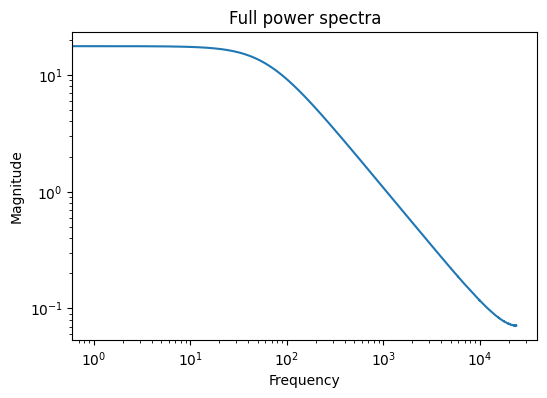

In [7]:
fig=plt.figure(figsize=(6, 4))
N = EKE1_slice.size

k_1 = fft(EKE1_slice)
k_1_mag = 1*np.abs(k_1[1:int(N/2)])+1*np.abs(k_1[-1:int(N/2):-1])


# k_2 = fft(EKE2_slice * window)
# k_2_mag = 1*np.abs(k_2[1:int(N/2)])+1*np.abs(k_2[-1:int(N/2):-1])

plt.loglog(np.arange(int(N/2)-1),k_1_mag ,label="$\mathrm{KE}_1$")
plt.title("Full power spectra")
plt.gca().set_ylabel("Magnitude")
plt.gca().set_xlabel("Frequency")
figname = "U" + U + "A" + A + "S" + S + "T" + T + "P"
# plt.savefig(figname, bbox_inches='tight')

Smoothing by dividing and running fft on a few parts

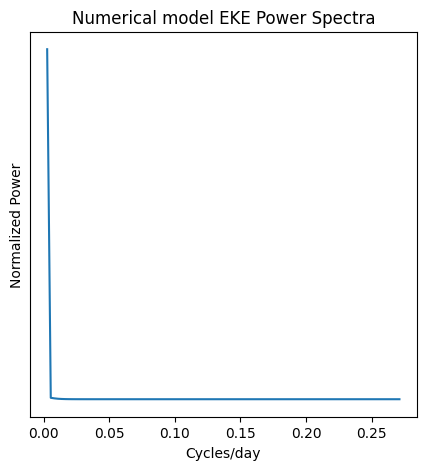

In [8]:
demean_EKE1 = EKE1_slice - np.mean(EKE1_slice)

f,P_den= signal.welch(demean_EKE1/np.linalg.norm(demean_EKE1,2), nperseg = 3650, axis = 0,window='hann')
plt.figure(figsize=(5, 5))

plt.plot(f[1:100]*10,P_den[1:100])
figname = "A" + A + "S" + S + "T" + T + "EKE"
plt.title("Numerical model EKE Power Spectra")
plt.gca().set_ylabel("Normalized Power")
plt.gca().set_xlabel("Cycles/day")

# Remove y-axis ticks and labels
plt.gca().get_yaxis().set_ticks([])  # Remove ticks
plt.gca().set_yticklabels([])  # Remove labels

plt.savefig(figname, bbox_inches='tight')
plt.show()

zooming in

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\o'
/state/partition1/job-60425157/ipykernel_3346020/2604274913.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(np.arange(1,data_mag.size+1),(data_mag),label="$\mathrm{KE}_1$");
/state/partition1/job-60425157/ipykernel_3346020/2604274913.py:10: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega$")


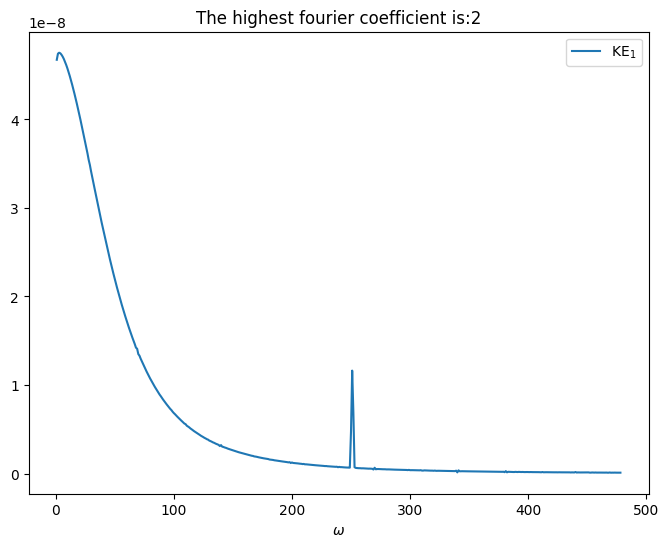

In [9]:
data = EKE1_slice
data = (data-np.mean(data))*window
data_hat = fft(data)
data_n = len(data_hat)
data_hat /= data_n
data_mag = 1*np.abs(data_hat[2:int(N/100)])+1*np.abs(data_hat[-2:-int(N/100):-1])

fig=plt.figure(figsize=(8, 6))
plt.plot(np.arange(1,data_mag.size+1),(data_mag),label="$\mathrm{KE}_1$");
plt.xlabel("$\omega$")
plt.legend()
plt.title("The highest fourier coefficient is:" + str(np.argmax(data_mag)))
figname = figname + "S"
# plt.savefig(figname, bbox_inches='tight')

Plotting EHF

In [10]:
EFH_slice = EFH[40000::10,:,:].ravel()
if len(EFH_slice) % 2 != 0:
    EFH_slice = EFH_slice[:-1]
print(EFH_slice.size)
window = signal.windows.hann(EFH_slice.size)

46000


<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/state/partition1/job-60425157/ipykernel_3346020/637731105.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.loglog(np.arange(int(N/2)-1),k_3_mag ,label="$\mathrm{KE}_1$"); # plt.ylim(1e-5,1e2)


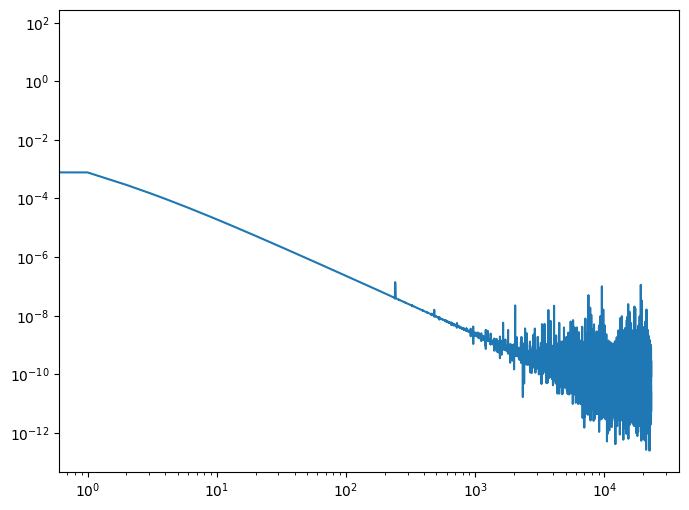

In [11]:
fig=plt.figure(figsize=(8, 6))
N=EFH_slice.size

k_3 = fft(EFH_slice * window)
k_3_mag = 1*np.abs(k_3[1:int(N/2)])+1*np.abs(k_3[-1:int(N/2):-1])

plt.loglog(np.arange(int(N/2)-1),k_3_mag ,label="$\mathrm{KE}_1$"); # plt.ylim(1e-5,1e2)

Smoothing

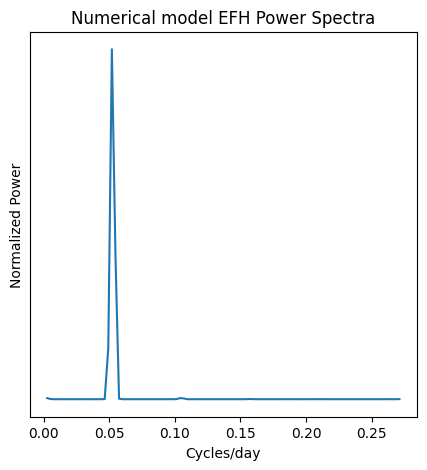

In [12]:
demean_EFH = EFH_slice - np.mean(EFH_slice)
plt.figure(figsize=(5, 5))
f,P_den= signal.welch(demean_EFH/np.linalg.norm(demean_EFH,2), nperseg = 3650, axis = 0)
plt.plot(f[1:100]*10,P_den[1:100])
figname = "A" + A + "S" + S + "T" + T + "EFH"
plt.title("Numerical model EFH Power Spectra")
plt.gca().set_ylabel("Normalized Power")
plt.gca().set_xlabel("Cycles/day")

# Remove y-axis ticks and labels
plt.gca().get_yaxis().set_ticks([])  # Remove ticks
plt.gca().set_yticklabels([])  # Remove labels
plt.savefig(figname, bbox_inches='tight')
plt.show()

Solve for DELU

2025-05-11 18:08:03,832 subsystems 0/1 INFO :: Building subproblem matrices 1/256 (~0%) Elapsed: 0s, Remaining: 28s, Rate: 9.3e+00/s
2025-05-11 18:08:04,744 subsystems 0/1 INFO :: Building subproblem matrices 26/256 (~10%) Elapsed: 1s, Remaining: 9s, Rate: 2.6e+01/s
2025-05-11 18:08:05,676 subsystems 0/1 INFO :: Building subproblem matrices 52/256 (~20%) Elapsed: 2s, Remaining: 8s, Rate: 2.7e+01/s
2025-05-11 18:08:06,603 subsystems 0/1 INFO :: Building subproblem matrices 78/256 (~30%) Elapsed: 3s, Remaining: 7s, Rate: 2.7e+01/s
2025-05-11 18:08:07,913 subsystems 0/1 INFO :: Building subproblem matrices 104/256 (~41%) Elapsed: 4s, Remaining: 6s, Rate: 2.5e+01/s
2025-05-11 18:08:08,856 subsystems 0/1 INFO :: Building subproblem matrices 130/256 (~51%) Elapsed: 5s, Remaining: 5s, Rate: 2.5e+01/s
2025-05-11 18:08:09,802 subsystems 0/1 INFO :: Building subproblem matrices 156/256 (~61%) Elapsed: 6s, Remaining: 4s, Rate: 2.6e+01/s
2025-05-11 18:08:10,827 subsystems 0/1 INFO :: Building subp

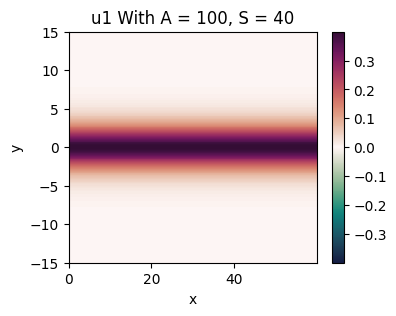

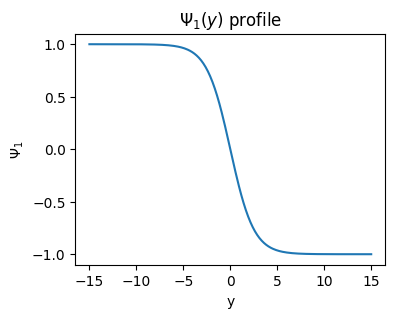

In [25]:
# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)

# Fields
u1 = dist.Field(name='u1', bases=(xbasis,ybasis))
v1 = dist.Field(name='v1', bases=(xbasis,ybasis))
Psi1 = dist.Field(name='Psi1', bases=(xbasis,ybasis))
q1 = dist.Field(name='q1', bases=(xbasis,ybasis))
u2 = dist.Field(name='u2', bases=(xbasis,ybasis))
v2 = dist.Field(name='v2', bases=(xbasis,ybasis))
Psi2 = dist.Field(name='Psi2', bases=(xbasis,ybasis))
q2 = dist.Field(name='q2', bases=(xbasis,ybasis))
Q1M = dist.Field(name='Q1M', bases=ybasis )
Q2M = dist.Field(name='Q2M', bases=ybasis )
tau_Psi1 = dist.Field(name='tau_Psi1')
tau_Psi2 = dist.Field(name='tau_Psi2')

tau_Psi1_b = dist.Field(name='tau_Psi1_b', bases=xbasis)
tau_Psi1_t = dist.Field(name='tau_Psi1_t', bases=xbasis)
tau_Psi2_b = dist.Field(name='tau_Psi2_b', bases=xbasis)
tau_Psi2_t = dist.Field(name='tau_Psi2_t', bases=xbasis)

tau_Psi1bc_t = dist.Field(name='tau_Psi1bc_t')
tau_Psi1bc_b = dist.Field(name='tau_Psi1bc_b')
tau_Psi2bc_t = dist.Field(name='tau_Psi2bc_t')
tau_Psi2bc_b = dist.Field(name='tau_Psi2bc_b')
# Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

dx = lambda A: d3.Differentiate(A, coords['x'])
dy = lambda A: d3.Differentiate(A, coords['y'])
lap = lambda A: d3.Laplacian(A)
xinteg = lambda A: d3.Integrate(A, ('x'))
yinteg = lambda A: d3.Integrate(A, ('y'))
integ = lambda A: d3.Integrate(A, ('x', 'y'))
xavg = lambda A: d3.Average(A, ('x'))
yavg = lambda A: d3.Average(A, ('y'))
avg = lambda A: d3.Average(A, ('x', 'y'))

x, y = dist.local_grids(xbasis, ybasis)

J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)

# Initial conditions
Amp = int(A) /100
Slope = int(S)/100
Q1M['g'] = 2*Amp*((Slope**2+1/2)*np.tanh(Slope*y) - (Slope**2)*np.tanh(Slope*y)**3)
Q2M['g'] = -2*Amp*((Slope**2+1/2)*np.tanh(Slope*y) - (Slope**2)*np.tanh(Slope*y)**3)
q1['g'] += Q1M['g']; q2['g'] += Q2M['g']

# Initial conditions: solve for streamfunction
problem = d3.LBVP([Psi1, Psi2, tau_Psi1, tau_Psi2, \
                  tau_Psi1bc_t, tau_Psi1bc_b, tau_Psi2bc_t, tau_Psi2bc_b, \
                  tau_Psi1_t, tau_Psi1_b, tau_Psi2_t, tau_Psi2_b
                    ], namespace=locals())
problem.add_equation("lap(Psi1)- k_d**2 / 2 * (Psi1-Psi2)+lift(tau_Psi1_b,-1)+lift(tau_Psi1_t,-2)+tau_Psi1=q1")
problem.add_equation("Psi1(y= Ly/2)-tau_Psi1bc_t=0");  problem.add_equation("Psi1(y=-Ly/2)-tau_Psi1bc_b=0")
problem.add_equation("xinteg(dy(Psi1)(y=Ly/2)) = 0"); problem.add_equation("xinteg(dy(Psi1)(y=-Ly/2)) = 0"); 

problem.add_equation("lap(Psi2)+ k_d**2 / 2 * (Psi1-Psi2)+lift(tau_Psi2_b,-1)+lift(tau_Psi2_t,-2)+tau_Psi2=q2")
problem.add_equation("Psi2(y= Ly/2)-tau_Psi2bc_t=0"); problem.add_equation("Psi2(y=-Ly/2)-tau_Psi2bc_b=0")
problem.add_equation("xinteg(dy(Psi2)(y=Ly/2)) = 0");  problem.add_equation("xinteg(dy(Psi2)(y=-Ly/2)) = 0")

problem.add_equation("integ(Psi1)=0")
problem.add_equation("integ(Psi2)=0")
solver = problem.build_solver()
solver.solve()

q1 = lap(Psi1) - 0.5 * k_d**2 * (Psi1 - Psi2)
u1 = -dy(Psi1)
v1 = dx(Psi1)
q2 = lap(Psi2) + 0.5 * k_d**2 * (Psi1 - Psi2)
u2 = -dy(Psi2)
v2 = dx(Psi2)

U1 = xinteg(u1) / Lx


# Evaluate the result
U1_value = U1.evaluate()

# Since 'evaluate' returns a field, we extract the scalar value using .value
U1_scalar = U1_value['g']

# Print the result
print(np.max(U1_scalar))

# Get the correct dealiased grid
x_dealias, y_dealias = dist.local_grids(xbasis, ybasis, scales=(dealias,dealias))

# Plot using the correct grid
plt.figure(figsize=(4, 3))
u1_data = u1.evaluate()['g']
plt.pcolormesh(x_dealias.ravel(), y_dealias.ravel(), u1_data.T, cmap=cmo.curl, norm=colors.CenteredNorm(), shading="auto")
plt.colorbar()
plt.title('u1 With A = ' + A +', S = ' + S)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('u1S'+ S + 'A' + A + '.png')
plt.show()

# Evaluate Psi1 (the streamfunction field)
Psi1_value = Psi1.evaluate()

# Take x-average to make it a function of y
Psi1_yavg = xavg(Psi1_value).evaluate()

# Get y-values correctly
y_vals = y_dealias[0, :]  # Correct shape matching

# Extract Psi1 values
Psi1_vals = Psi1_yavg['g'][0, :]  # Also along axis 0

# Plot Psi1 vs y
plt.figure(figsize=(4, 3))
plt.plot(y_vals, Psi1_vals)
plt.xlabel('y')
plt.ylabel(r'$\Psi_1$')
plt.title(r'$\Psi_1(y)$ profile')
plt.savefig('psi1S'+ S + 'A' + A + '.png')
plt.show()



In [77]:
U= '5'
A= '60'
S= '60'
T= '50'


snapname = '/scratch/ql2221/dedalus_sing/Channel/channel_snap_U' + U + 'A' + str(A) + 'S' + str(S) +'T' + str(T) + '/channel_snap_U' + U + 'A' + str(A) + 'S' + str(S) +'T' + str(T) + '_s60.h5'
with h5py.File(snapname, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))
    
    # Psi1_data = np.squeeze(np.array(file['tasks']['Psi1']))
    # Psi2_data = np.squeeze(np.array(file['tasks']['Psi2']))
    
    
    q1_data = np.squeeze(np.array(file['tasks']['q1']))
    q2_data = np.squeeze(np.array(file['tasks']['q2']))
    
    zeta_1_data = np.squeeze(np.array(file['tasks']['zeta_1']))
    zeta_2_data = np.squeeze(np.array(file['tasks']['zeta_2']))
    
    # Psi_data = np.squeeze(np.array(file['tasks']['Psi']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    
    x = np.array(file['scales'][list(file['scales'])[-2]])
    y = np.array(file['scales'][list(file['scales'])[-1]])

['scales', 'tasks']
<HDF5 group "/scales" (8 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'write_number', 'x_hash_726b6cff477fed92c3f98165e3a61f798557e581', 'y_hash_9ba114016e0b5713fe541c50a2cc326cfedb8299']
<HDF5 group "/tasks" (4 members)>
['q1', 'q2', 'zeta_1', 'zeta_2']


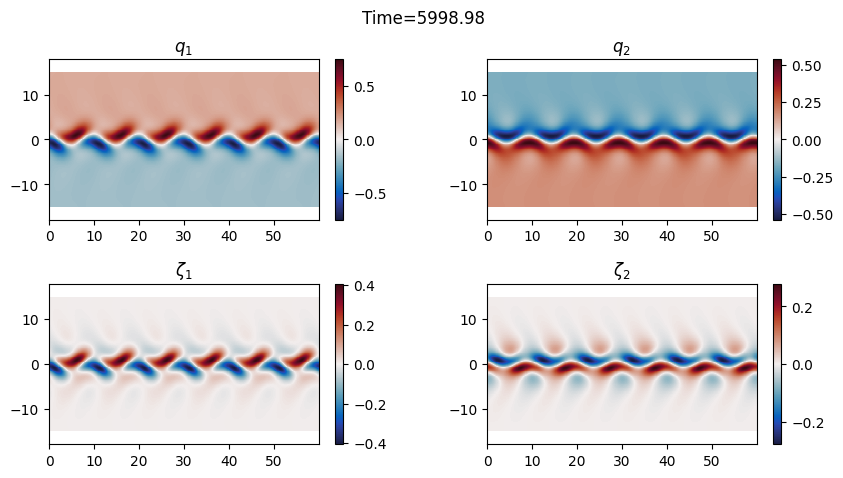

In [78]:
time_idx = -1
L = x[-1]+(x[-1]-x[-2])

fig=plt.figure(figsize=(10, 5))

fig.suptitle('Time=%.2f' %(sim_time_ary[time_idx]), y=0.98)
plt.subplot(2, 2, 1)
plt.pcolormesh(x,y,(q1_data[time_idx,:,:]).T, cmap=cmo.balance, norm=colors.CenteredNorm()) 

plt.axis('equal')
cbar = plt.colorbar();
plt.title(r'$q_1$')

plt.subplot(2, 2, 3)
zmax = np.max(abs(zeta_1_data[time_idx,:,:]))/1
plt.pcolormesh(x,y,zeta_1_data[time_idx,:,:].T, cmap=cmo.balance, vmin=-zmax, vmax=zmax)
plt.axis('equal')
cbar = plt.colorbar();
plt.title(r'$\zeta_1$')


plt.subplot(2, 2, 2)
plt.pcolormesh(x,y,(q2_data[time_idx,:,:]).T, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.axis('equal')
cbar = plt.colorbar();
plt.title(r'$q_2$')

plt.subplot(2, 2, 4)
zmax = np.max(abs(zeta_2_data[time_idx,:,:]))/1
plt.pcolormesh(x,y,zeta_2_data[time_idx,:,:].T, cmap=cmo.balance, vmin=-zmax, vmax=zmax)
plt.axis('equal')
cbar = plt.colorbar();
plt.title(r'$\zeta_2$')

plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()